In [1]:
!pip install boto3
#!pip install snowflake-connector-python==2.7.4
!pip install "snowflake-connector-python[secure-local-storage,pandas]"
!pip install pyarrow

In [1]:
import getpass
import os
print(os.getcwd())

def set_notebooks_working_dir():
    current_dir = os.getcwd()
    current_username = 'Nikita'

    if current_dir.startswith("/home/jovyan/"):
        os.chdir(f"/home/jovyan/{current_username}/DST_CA_DE")
    else:
        raise Warning("Unexpected current working directory. Code does not know how to re-route to source. Please update")
    print(f"\n Effective working directory: \n{os.getcwd()}")
    
set_notebooks_working_dir()

/home/jovyan/Nikita/DST_CA_DE/notebooks

 Effective working directory: 
/home/jovyan/Nikita/DST_CA_DE


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
import base64
import json
from itertools import product
import snowflake.connector as snowflake
from botocore.exceptions import ClientError
import numpy as np
from sklearn.preprocessing import StandardScaler

# Display all columns and their data
pd.set_option('display.max_columns', None)  # Set to None to display all columns

In [3]:
from src.utils import stats_utils as stats

In [4]:
# ACT 1: Getting the secrets from AWS Secret Manager
def get_secret(field):
    secret_name="F1_CDHDEAHA_ONCO"
    secrets = boto3.client(service_name='secretsmanager', region_name="eu-west-1")
    response = secrets.get_secret_value(
        SecretId=secret_name
    )
    return json.loads(response['SecretString'])[field]

In [5]:
# ACT 2: Connecting to the database 
ctx = snowflake.connect(
user=get_secret('SYS_F1_SNOD_CDHDEAHA_ID'),
password=get_secret('SYS_F1_SNOD_CDHDEAHA_TOKEN'),
account='nvs8prdeuwest1.eu-west-1',
warehouse= 'CDHIM_WH_M',
database= 'PUBLISH_DB',
schema= 'IMI_DATA_PRODUCTS_DE',
role='F1_PRD_SNO_IMI_PRODUCT_DE_DATA_ANALYST'
)
cs=ctx.cursor()

In [6]:
def run_sql_imi_ards(table_name) -> pd.DataFrame:
    ctx = snowflake.connect(
        user=get_secret('SYS_F1_SNOD_CDHDEAHA_ID'),
        password=get_secret('SYS_F1_SNOD_CDHDEAHA_TOKEN'),
        account='nvs8prdeuwest1.eu-west-1',
        warehouse= 'CDHIM_WH_M',
        database= 'PUBLISH_DB',
        schema= 'IMI_DATA_PRODUCTS_DE',
        role='F1_PRD_SNO_IMI_PRODUCT_DE_DATA_ANALYST'
    )
    cur=ctx.cursor()
    sql = f"SELECT * FROM {table_name} WHERE COUNTRY_ISO2_CODE = 'DE'"
    # run the sql query
    cur.execute(sql) 
    df = cur.fetch_pandas_all()
    print(f"request done; result has {len(df)} rows and {len(df.columns)} columns")
    return df


def remove_audit_cols(df):
    # Remove columns starting with "Audit"
    columns_to_remove = [col for col in df.columns if col.startswith(("AUDIT", "SOURC", "SYSTEMN_COL", "SRC_"))]
    return df.drop(columns=columns_to_remove)

def find_common_columns(dataframes):
    # Get the column names from the first DataFrame
    common_columns = set(dataframes[0].columns)
    
    # Iterate over the remaining DataFrames
    for df in dataframes[1:]:
        # Intersect the set of column names with the current DataFrame's columns
        common_columns = common_columns.intersection(set(df.columns))
    
    return common_columns

In [7]:
table_name = "ARD_INTRCTN_AGGR_CUST_PROD_BRND_TERR_EMP_LVL_DLY"
ARD_INTRCTN_AGGR_CUST_PROD_BRND_TERR_EMP_LVL_DLY = run_sql_imi_ards(table_name)
ARD_INTRCTN_AGGR_CUST_PROD_BRND_TERR_EMP_LVL_DLY = remove_audit_cols(ARD_INTRCTN_AGGR_CUST_PROD_BRND_TERR_EMP_LVL_DLY)

request done; result has 5863487 rows and 39 columns


In [8]:
ARD_INTRCTN_AGGR_CUST_PROD_BRND_TERR_EMP_LVL_DLY.columns

Index(['COUNTRY_ISO2_CODE', 'CUST_ID', 'PROD_ID', 'TERR_ID', 'TERR_NAME',
       'PROD_NM', 'BRND_NM', 'SLS_LN_CD', 'CALL_FOCUS', 'INTRCTN_STATUS',
       'CALL_ATTENDEE_TYP', 'BUSINESS_UNIT', 'DIVISION', 'CALL_PRIORITY',
       'INTRCTN_MTHD', 'INTRCTN_MTHD_UPD', 'EMP_ID', 'DATA_PERIOD_MTH',
       'TOT_RCH_TCHPNT_CNT', 'TOT_DIALOG_CNT', 'TOT_F2F_CALL_CNT',
       'TOT_VIRTUAL_CALL_CNT', 'TOT_PHN_CALL_CNT', 'TOT_OTHR_CALL_CNT',
       'TOT_RTE_SNT_CNT', 'TOT_RTE_CLK_CNT', 'TOT_RTE_OPN_CNT',
       'TOT_RTE_OPN_RT', 'TOT_RTE_CLK_THRU_RT', 'TOT_HQ_SNT_CNT',
       'TOT_HQ_CLK_CNT', 'TOT_HQ_OPN_CNT', 'TOT_HQ_OPN_RT',
       'TOT_HQ_CLK_THRU_RT'],
      dtype='object')

In [9]:
# Calculate the percentage of null values in each column
print(f"Percentage of null values in CUST PROFILE  \
      {(ARD_INTRCTN_AGGR_CUST_PROD_BRND_TERR_EMP_LVL_DLY.isnull().sum() / len(ARD_INTRCTN_AGGR_CUST_PROD_BRND_TERR_EMP_LVL_DLY)) * 100}")

Percentage of null values in CUST PROFILE        COUNTRY_ISO2_CODE        0.000000
CUST_ID                  0.000341
PROD_ID                  0.000000
TERR_ID                  1.864539
TERR_NAME                1.864539
PROD_NM                  0.000000
BRND_NM                 15.093527
SLS_LN_CD                2.688827
CALL_FOCUS              21.002247
INTRCTN_STATUS          17.720872
CALL_ATTENDEE_TYP       17.721315
BUSINESS_UNIT            2.688741
DIVISION                 2.688741
CALL_PRIORITY           17.720872
INTRCTN_MTHD            18.568473
INTRCTN_MTHD_UPD        17.720872
EMP_ID                   1.864539
DATA_PERIOD_MTH          0.000000
TOT_RCH_TCHPNT_CNT       0.000000
TOT_DIALOG_CNT           0.000000
TOT_F2F_CALL_CNT         0.000000
TOT_VIRTUAL_CALL_CNT     0.000000
TOT_PHN_CALL_CNT         0.000000
TOT_OTHR_CALL_CNT        0.000000
TOT_RTE_SNT_CNT          0.000000
TOT_RTE_CLK_CNT          0.000000
TOT_RTE_OPN_CNT          0.000000
TOT_RTE_OPN_RT           0.000000

In [10]:
ARD_INTRCTN_AGGR_CUST_PROD_BRND_TERR_EMP_LVL_DLY.INTRCTN_MTHD_UPD.value_counts()

Face to Face    3814104
Phone            535694
Mail             214915
Virtual           78580
Postal            70338
Other             62723
MISSING           46181
Fax                1871
Event                20
Name: INTRCTN_MTHD_UPD, dtype: int64

In [11]:
ARD_INTRCTN_AGGR_CUST_PROD_BRND_TERR_EMP_LVL_DLY.groupby(['CALL_FOCUS', 'INTRCTN_MTHD_UPD'])['CUST_ID'].count()

CALL_FOCUS                  INTRCTN_MTHD_UPD
Non-promotional discussion  Face to Face         302298
                            Fax                     712
                            MISSING                  10
                            Mail                  73118
                            Other                 18194
                            Phone                111036
                            Postal                18413
                            Virtual                7740
Other                       Face to Face          18301
                            Fax                     184
                            Mail                  21892
                            Other                  7392
                            Phone                 16926
                            Postal                 7792
                            Virtual                2120
Other_old                   Face to Face           1586
                            Phone                     2
Pro

In [12]:
comm_df = ARD_INTRCTN_AGGR_CUST_PROD_BRND_TERR_EMP_LVL_DLY[(ARD_INTRCTN_AGGR_CUST_PROD_BRND_TERR_EMP_LVL_DLY.DIVISION == "COMMERCIAL") & (ARD_INTRCTN_AGGR_CUST_PROD_BRND_TERR_EMP_LVL_DLY.BRND_NM == 'KISQALI') & (ARD_INTRCTN_AGGR_CUST_PROD_BRND_TERR_EMP_LVL_DLY.BUSINESS_UNIT == 'Oncology')]
med_df = ARD_INTRCTN_AGGR_CUST_PROD_BRND_TERR_EMP_LVL_DLY[(ARD_INTRCTN_AGGR_CUST_PROD_BRND_TERR_EMP_LVL_DLY.DIVISION == "MEDICAL") & (ARD_INTRCTN_AGGR_CUST_PROD_BRND_TERR_EMP_LVL_DLY.BRND_NM == 'KISQALI') & (ARD_INTRCTN_AGGR_CUST_PROD_BRND_TERR_EMP_LVL_DLY.BUSINESS_UNIT == 'Oncology Medical')]
assert sum(comm_df.BUSINESS_UNIT == 'Oncology') == len(comm_df)
assert sum(med_df.BUSINESS_UNIT == 'Oncology Medical') == len(med_df)

print("Commercial Data ", len(comm_df.index), '|', comm_df["CUST_ID"].nunique())
print("Medical Data     ", len(med_df.index), '|', med_df["CUST_ID"].nunique())

Commercial Data  171369 | 10303
Medical Data      13954 | 3094


In [13]:
table_name = "DIM_CUST_PROFILE"
DIM_CUST_PROFILE = run_sql_imi_ards(table_name)
DIM_CUST_PROFILE = remove_audit_cols(DIM_CUST_PROFILE)

request done; result has 390092 rows and 30 columns


In [14]:
DIM_CUST_PROFILE.columns

Index(['COUNTRY_ISO2_CODE', 'CUST_ID', 'CUST_UNIQ_ID', 'FRST_NM', 'LST_NM',
       'FULL_NM', 'SALUTATN', 'TITLE', 'GNDR', 'AGE', 'STATUS', 'KOL_IND',
       'PDRP_IND', 'ADDR', 'POSTAL_CD', 'CITY_NM', 'PRIM_ADDR_IND', 'SPEC_NM',
       'PHN_NUM', 'EMAIL', 'LINKEDIN_URL', 'TWITTER_URL', 'LST_CALL_DT',
       'LST_CALL_EMP_ID', 'LST_CALL_EMP_NM'],
      dtype='object')

In [15]:
# Calculate the percentage of null values in each column
print(f"Percentage of null values in CUST PROFILE  \
      {(DIM_CUST_PROFILE.isnull().sum() / len(DIM_CUST_PROFILE)) * 100}")

Percentage of null values in CUST PROFILE        COUNTRY_ISO2_CODE      0.000000
CUST_ID                0.000000
CUST_UNIQ_ID           0.000000
FRST_NM                0.000256
LST_NM                 0.000000
FULL_NM                0.000000
SALUTATN               0.000000
TITLE                  0.000000
GNDR                   0.000000
AGE                   99.954370
STATUS                 0.000000
KOL_IND                0.000000
PDRP_IND               0.000000
ADDR                   0.033325
POSTAL_CD              0.033325
CITY_NM                0.033325
PRIM_ADDR_IND          0.000000
SPEC_NM                0.000000
PHN_NUM               99.928735
EMAIL                 85.517519
LINKEDIN_URL         100.000000
TWITTER_URL          100.000000
LST_CALL_DT           74.560616
LST_CALL_EMP_ID       74.560616
LST_CALL_EMP_NM       74.560616
dtype: float64


In [16]:
sum(DIM_CUST_PROFILE.EMAIL.isnull()), len(DIM_CUST_PROFILE)

(333597, 390092)

In [17]:
table_name = "DIM_CUST_SGMNT"
DIM_CUST_SGMNT = run_sql_imi_ards(table_name)
DIM_CUST_SGMNT = remove_audit_cols(DIM_CUST_SGMNT)
DIM_CUST_SGMNT = DIM_CUST_SGMNT[['CUST_ID', 'TIER', 'SGMNT_TYP', 'SGMNT_SRC_ID','SGMNT_VAL', 'SPEC_NM']]

request done; result has 257632 rows and 16 columns


In [18]:
DIM_CUST_SGMNT.columns

Index(['CUST_ID', 'TIER', 'SGMNT_TYP', 'SGMNT_SRC_ID', 'SGMNT_VAL', 'SPEC_NM'], dtype='object')

In [19]:
table_name = "DIM_CUST_HCO_AFLTN"
DIM_CUST_HCO_AFLTN = run_sql_imi_ards(table_name)
DIM_CUST_HCO_AFLTN = remove_audit_cols(DIM_CUST_HCO_AFLTN)

request done; result has 1450340 rows and 24 columns


In [20]:
DIM_CUST_HCO_AFLTN.columns

Index(['COUNTRY_ISO2_CODE', 'CUST_ID', 'CUST_FRST_NM', 'CUST_LST_NM',
       'CUST_FULL_NM', 'CUST_KOL_IND', 'ORG_ID', 'ORG_TYP', 'ORG_NM',
       'ORG_ADDR', 'ORG_EMAIL', 'ORG_PHN_NUM', 'ORG_KEY_IND', 'EMP_ID',
       'EMP_NM', 'EMP_ROLE', 'SLS_LN_CD', 'BRICK', 'PARENT_ACCOUNT'],
      dtype='object')

In [21]:
merged_df = ARD_INTRCTN_AGGR_CUST_PROD_BRND_TERR_EMP_LVL_DLY.merge(DIM_CUST_PROFILE, on=['CUST_ID', 'COUNTRY_ISO2_CODE'])

In [22]:
merged_df.columns

Index(['COUNTRY_ISO2_CODE', 'CUST_ID', 'PROD_ID', 'TERR_ID', 'TERR_NAME',
       'PROD_NM', 'BRND_NM', 'SLS_LN_CD', 'CALL_FOCUS', 'INTRCTN_STATUS',
       'CALL_ATTENDEE_TYP', 'BUSINESS_UNIT', 'DIVISION', 'CALL_PRIORITY',
       'INTRCTN_MTHD', 'INTRCTN_MTHD_UPD', 'EMP_ID', 'DATA_PERIOD_MTH',
       'TOT_RCH_TCHPNT_CNT', 'TOT_DIALOG_CNT', 'TOT_F2F_CALL_CNT',
       'TOT_VIRTUAL_CALL_CNT', 'TOT_PHN_CALL_CNT', 'TOT_OTHR_CALL_CNT',
       'TOT_RTE_SNT_CNT', 'TOT_RTE_CLK_CNT', 'TOT_RTE_OPN_CNT',
       'TOT_RTE_OPN_RT', 'TOT_RTE_CLK_THRU_RT', 'TOT_HQ_SNT_CNT',
       'TOT_HQ_CLK_CNT', 'TOT_HQ_OPN_CNT', 'TOT_HQ_OPN_RT',
       'TOT_HQ_CLK_THRU_RT', 'CUST_UNIQ_ID', 'FRST_NM', 'LST_NM', 'FULL_NM',
       'SALUTATN', 'TITLE', 'GNDR', 'AGE', 'STATUS', 'KOL_IND', 'PDRP_IND',
       'ADDR', 'POSTAL_CD', 'CITY_NM', 'PRIM_ADDR_IND', 'SPEC_NM', 'PHN_NUM',
       'EMAIL', 'LINKEDIN_URL', 'TWITTER_URL', 'LST_CALL_DT',
       'LST_CALL_EMP_ID', 'LST_CALL_EMP_NM'],
      dtype='object')

In [23]:
comm_df = merged_df[(merged_df.DIVISION == "COMMERCIAL") & (merged_df.BRND_NM == 'KISQALI') & (merged_df.BUSINESS_UNIT == 'Oncology')]
med_df = merged_df[(merged_df.DIVISION == "MEDICAL") & (merged_df.BRND_NM == 'KISQALI') & (merged_df.BUSINESS_UNIT == 'Oncology Medical')]
assert sum(comm_df.BUSINESS_UNIT == 'Oncology') == len(comm_df)
assert sum(med_df.BUSINESS_UNIT == 'Oncology Medical') == len(med_df)

print("Commercial Data ", len(comm_df.index), '|', comm_df["CUST_ID"].nunique())
print("Medical Data     ", len(med_df.index), '|', med_df["CUST_ID"].nunique())

Commercial Data  105614 | 7065
Medical Data      10059 | 2496


### CUST_ID & CUST_UNIQ_ID

In [24]:
# Check if the values in the CUST_ID &  CUST_UNIQ_ID columns are equal
are_equal = (merged_df['CUST_ID'] == merged_df['CUST_UNIQ_ID'])
print(len(are_equal))

# Print the rows where the values are not equal
rows_with_different_values = merged_df[~are_equal]

# If the two columns have the same data values, rows_with_different_values will be empty
if rows_with_different_values.empty:
    print("The CUST_ID and  CUST_UNIQ_ID columns have the same data values.")
else:
    print("The CUST_ID and  CUST_UNIQ_ID columns have different data values in the following rows:")
    print(rows_with_different_values[['CUST_ID', 'CUST_UNIQ_ID']].head(10))
    print()
    print(rows_with_different_values['CUST_UNIQ_ID'].value_counts())


3552674
The CUST_ID and  CUST_UNIQ_ID columns have the same data values.


In [25]:
# Drop 'CUST_UNIQ_ID' columns 
drop_cols = ['CUST_UNIQ_ID', 'COUNTRY_ISO2_CODE']

# Drop the specified columns
merged_df = merged_df.drop(columns=drop_cols)


In [26]:
merged_df.columns

Index(['CUST_ID', 'PROD_ID', 'TERR_ID', 'TERR_NAME', 'PROD_NM', 'BRND_NM',
       'SLS_LN_CD', 'CALL_FOCUS', 'INTRCTN_STATUS', 'CALL_ATTENDEE_TYP',
       'BUSINESS_UNIT', 'DIVISION', 'CALL_PRIORITY', 'INTRCTN_MTHD',
       'INTRCTN_MTHD_UPD', 'EMP_ID', 'DATA_PERIOD_MTH', 'TOT_RCH_TCHPNT_CNT',
       'TOT_DIALOG_CNT', 'TOT_F2F_CALL_CNT', 'TOT_VIRTUAL_CALL_CNT',
       'TOT_PHN_CALL_CNT', 'TOT_OTHR_CALL_CNT', 'TOT_RTE_SNT_CNT',
       'TOT_RTE_CLK_CNT', 'TOT_RTE_OPN_CNT', 'TOT_RTE_OPN_RT',
       'TOT_RTE_CLK_THRU_RT', 'TOT_HQ_SNT_CNT', 'TOT_HQ_CLK_CNT',
       'TOT_HQ_OPN_CNT', 'TOT_HQ_OPN_RT', 'TOT_HQ_CLK_THRU_RT', 'FRST_NM',
       'LST_NM', 'FULL_NM', 'SALUTATN', 'TITLE', 'GNDR', 'AGE', 'STATUS',
       'KOL_IND', 'PDRP_IND', 'ADDR', 'POSTAL_CD', 'CITY_NM', 'PRIM_ADDR_IND',
       'SPEC_NM', 'PHN_NUM', 'EMAIL', 'LINKEDIN_URL', 'TWITTER_URL',
       'LST_CALL_DT', 'LST_CALL_EMP_ID', 'LST_CALL_EMP_NM'],
      dtype='object')

In [27]:
df = merged_df[merged_df.BRND_NM == 'KISQALI']

## KISQALI Analysis

In [28]:
# Find duplicated rows based on all columns
duplicates = df[df.duplicated()]
print(len(duplicates))
print()
print(duplicates)

0

Empty DataFrame
Columns: [CUST_ID, PROD_ID, TERR_ID, TERR_NAME, PROD_NM, BRND_NM, SLS_LN_CD, CALL_FOCUS, INTRCTN_STATUS, CALL_ATTENDEE_TYP, BUSINESS_UNIT, DIVISION, CALL_PRIORITY, INTRCTN_MTHD, INTRCTN_MTHD_UPD, EMP_ID, DATA_PERIOD_MTH, TOT_RCH_TCHPNT_CNT, TOT_DIALOG_CNT, TOT_F2F_CALL_CNT, TOT_VIRTUAL_CALL_CNT, TOT_PHN_CALL_CNT, TOT_OTHR_CALL_CNT, TOT_RTE_SNT_CNT, TOT_RTE_CLK_CNT, TOT_RTE_OPN_CNT, TOT_RTE_OPN_RT, TOT_RTE_CLK_THRU_RT, TOT_HQ_SNT_CNT, TOT_HQ_CLK_CNT, TOT_HQ_OPN_CNT, TOT_HQ_OPN_RT, TOT_HQ_CLK_THRU_RT, FRST_NM, LST_NM, FULL_NM, SALUTATN, TITLE, GNDR, AGE, STATUS, KOL_IND, PDRP_IND, ADDR, POSTAL_CD, CITY_NM, PRIM_ADDR_IND, SPEC_NM, PHN_NUM, EMAIL, LINKEDIN_URL, TWITTER_URL, LST_CALL_DT, LST_CALL_EMP_ID, LST_CALL_EMP_NM]
Index: []


## TERRITORY

In [29]:
print(f"different TERR_ID avaialble: {len(df.TERR_ID.unique())}")
print(f"different TERR_NAME avaialble: {len(df.TERR_NAME.unique())}")

different TERR_ID avaialble: 86
different TERR_NAME avaialble: 85


In [30]:
# check for null values and remove them 
TERR_ID_null = df[df["TERR_ID"].isnull()]
print(f"TERRITORY ID is NULL {len(TERR_ID_null.index)} /  {len(df.index)}")
df = df[~df["TERR_ID"].isnull()] 
print(f"TERRITORY ID not NULL after nulls are removed: {len(df)}")
print(f"Different TERR_ID avaialble after null removed: {len(df.TERR_ID.unique())}")

TERRITORY ID is NULL 4097 /  119788
TERRITORY ID not NULL after nulls are removed: 115691
Different TERR_ID avaialble after null removed: 85


In [31]:
# Add "unknown" to the "TERR_NAME" column when "TERR_ID" is null
df['TERR_NAME'].fillna('unknown', inplace=True)

## INTRCTN_STATUS

In [32]:
print("<initial count>                      ", len(df.index), '|', df["CUST_ID"].nunique())
df = df.query("INTRCTN_STATUS == 'Submitted_vod'")
print("<INTERACTION_STATUS == 'Submitted_vod'>", len(df.index), '|', df["CUST_ID"].nunique())

<initial count>                       115691 | 7280
<INTERACTION_STATUS == 'Submitted_vod'> 92206 | 7023


## CALL_FOCUS

In [33]:
df_com = df.query("CALL_FOCUS == 'Promotional discussion' or CALL_FOCUS == 'Service' or CALL_FOCUS == 'Non-promotional discussion'")
print("<CALL_FOCUS is Commercial>", len(df_com.index), '|', df_com["CUST_ID"].nunique())
print()
df_med = df[(df['CALL_FOCUS'].isnull()) & (df['DIVISION'] == 'MEDICAL')]
print("<CALL_FOCUS is Medical>", len(df_med.index), '|', df_med["CUST_ID"].nunique())


<CALL_FOCUS is Commercial> 83808 | 6805

<CALL_FOCUS is Medical> 7268 | 1485


## PRODUCTS

In [34]:
# Group by 'PROD_ID' and count unique 'CUST_ID' values
product_cust_count = df.groupby(['PROD_ID', 'PROD_NM'])['CUST_ID'].nunique()

# Print the product IDs and the corresponding unique CUST_ID counts
for product_id, product_name in product_cust_count.items():
    print(f"Product ID & NAME: {product_id},  Unique Customer Count: {product_name}")

Product ID & NAME: ('a000B00000hu9F5QAI', 'MaCa-CDK4/6'),  Unique Customer Count: 6822
Product ID & NAME: ('a006f00000drt9YAAQ', 'MammaCA-Ribociclib'),  Unique Customer Count: 623
Product ID & NAME: ('a006f00000dsldlAAA', 'MammaCA-adj-Ribociclib'),  Unique Customer Count: 531
Product ID & NAME: ('a006f00000dsldvAAA', 'MammaCA-met-Ribociclib'),  Unique Customer Count: 1134


In [35]:
nunique_products = df.groupby("CUST_ID")["PROD_ID"].nunique().reset_index().rename(columns={"PROD_ID" : "MARKETING_PRODUCT_COUNT"})
df = pd.merge(df, nunique_products, how="left", on="CUST_ID")

In [36]:
total_products = df.groupby("CUST_ID")["PROD_ID"].count().reset_index().rename(columns={"PROD_ID" : "total_products"})
total_products.head()
df = pd.merge(df, total_products, how="left", on="CUST_ID")

In [37]:
#check for duplicated entires
print("entries where total_products != MARKETING_PRODUCT_COUNT", len(df[df["total_products"] != df["MARKETING_PRODUCT_COUNT"]].index))

# this means we have duplicate rows in our dataset; we calculate the dups here FILTERED to
# only the entries where total_products != unique_products
check_dups = df[df["total_products"] != df["MARKETING_PRODUCT_COUNT"]].duplicated()
entries_with_dups = df[df["total_products"] != df["MARKETING_PRODUCT_COUNT"]][check_dups]
print("duplicate entries where total_products != MARKETING_PRODUCT_COUNT", len(entries_with_dups.index))

# we further verify that these duplicate entries are all the duplicate entries that we have here
# i.e., without selection of the subset where total_products != unique_products
print("duplicate entries overall:", len(df[df.duplicated()].index))

# and make sure that they are actually the same (just to be safe here)
assert(entries_with_dups.equals(df[df.duplicated()]))


entries where total_products != MARKETING_PRODUCT_COUNT 90511
duplicate entries where total_products != MARKETING_PRODUCT_COUNT 0
duplicate entries overall: 0


### Date 

In [38]:
df["DATA_PERIOD_MTH"] = pd.to_datetime(df["DATA_PERIOD_MTH"])
# Derive features for month and year
df['Month'] = df['DATA_PERIOD_MTH'].dt.month
df['Year'] = df['DATA_PERIOD_MTH'].dt.year

print(f"Data is available from {df['DATA_PERIOD_MTH'].min()}  to  {df['DATA_PERIOD_MTH'].max()}")

# Create a reference list of all possible year-month combinations
all_year_month_combinations = list(product(range(df["DATA_PERIOD_MTH"].min().year, df["DATA_PERIOD_MTH"].max().year + 1), range(1, 13)))

# Group data by year and month
grouped = df.groupby(['Year', 'Month']).size()

# Check for missing year-month combinations
missing_combinations = [comb for comb in all_year_month_combinations if comb not in grouped.index]

if not missing_combinations:
    print()
    print("Data is available for every year and every month.")
else:
    print()
    print("Missing year-month combinations:")
    print(missing_combinations)

Data is available from 2019-01-01 00:00:00  to  2023-08-01 00:00:00

Missing year-month combinations:
[(2023, 9), (2023, 10), (2023, 11), (2023, 12)]


<AxesSubplot:>

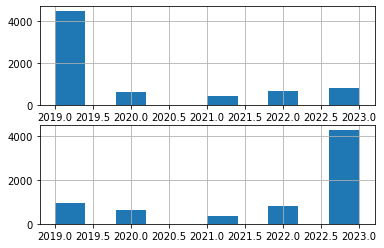

In [39]:
# maximum and minimum interactions time-wise per HCP
fix, axes = plt.subplots(2)
df.groupby("CUST_ID")["Year"].min().hist(ax=axes[0])
df.groupby("CUST_ID")["Year"].max().hist(ax=axes[1])

In [40]:
print("Number of hcps:", df["CUST_ID"].nunique())
print("Number of months_under_observation:", df["DATA_PERIOD_MTH"].nunique())
print("First month:", df["DATA_PERIOD_MTH"].min())
print("Last month:", df["DATA_PERIOD_MTH"].max())

Number of hcps: 7023
Number of months_under_observation: 56
First month: 2019-01-01 00:00:00
Last month: 2023-08-01 00:00:00


## HCPs

In [41]:
rename_cols ={'TITLE' : 'HCP_TYPE',
             'FRST_NM' : 'HCP_FRST_NM',
             'LST_NM': 'HCP_LST_NM',
             'FULL_NM': 'HCP_FULL_NM',
             'STATUS': 'HCP_STATUS',
              'AGE': 'HCP_AGE',
             'GNDR': 'HCP_GNDR',
             'KOL_IND': 'KOL_IND',
             'POSTAL_CD':'HCP_POSTAL_CD',
              'CITY_NM':'HCP_CITY_NM',
              'ADDR' : 'HCP_ADDR',
              'PHN_NUM' : 'HCP_PHN_NUM',
              'EMAIL' : 'HCP_EMAIL',
              'LINKEDIN_URL' :"HCP_LINKEDIN_URL",
              'TWITTER_URL' :"HCP_TWITTER_URL",
              'SPEC_NM_x' : 'HCP_SPEC_NM',
              'SPEC_NM_y': 'HCP_SPEC_SUB_NM'
              
             }
            
df.rename(columns=rename_cols, inplace=True)



# Check PRIM_ADDR_IND is True
print(df.PRIM_ADDR_IND.value_counts())
print("PRIMARY ADDRESS INDICATOR entries :", len(df[df.PRIM_ADDR_IND == 1].index)) 

1    92189
0       17
Name: PRIM_ADDR_IND, dtype: int64
PRIMARY ADDRESS INDICATOR entries : 92189


In [42]:
df[(df.CUST_ID == '001U000000TOvbxIAD') & (df.DATA_PERIOD_MTH == '2019-01')]

,CUST_ID,PROD_ID,TERR_ID,TERR_NAME,PROD_NM,BRND_NM,SLS_LN_CD,CALL_FOCUS,INTRCTN_STATUS,CALL_ATTENDEE_TYP,BUSINESS_UNIT,DIVISION,CALL_PRIORITY,INTRCTN_MTHD,INTRCTN_MTHD_UPD,EMP_ID,DATA_PERIOD_MTH,TOT_RCH_TCHPNT_CNT,TOT_DIALOG_CNT,TOT_F2F_CALL_CNT,TOT_VIRTUAL_CALL_CNT,TOT_PHN_CALL_CNT,TOT_OTHR_CALL_CNT,TOT_RTE_SNT_CNT,TOT_RTE_CLK_CNT,TOT_RTE_OPN_CNT,TOT_RTE_OPN_RT,TOT_RTE_CLK_THRU_RT,TOT_HQ_SNT_CNT,TOT_HQ_CLK_CNT,TOT_HQ_OPN_CNT,TOT_HQ_OPN_RT,TOT_HQ_CLK_THRU_RT,HCP_FRST_NM,HCP_LST_NM,HCP_FULL_NM,SALUTATN,HCP_TYPE,HCP_GNDR,HCP_AGE,HCP_STATUS,KOL_IND,PDRP_IND,HCP_ADDR,HCP_POSTAL_CD,HCP_CITY_NM,PRIM_ADDR_IND,SPEC_NM,HCP_PHN_NUM,HCP_EMAIL,HCP_LINKEDIN_URL,HCP_TWITTER_URL,LST_CALL_DT,LST_CALL_EMP_ID,LST_CALL_EMP_NM,MARKETING_PRODUCT_COUNT,total_products,Month,Year
28457,001U000000TOvbxIAD,a000B00000hu9F5QAI,0MI6f00000004h9GAA,01450045304,MaCa-CDK4/6,KISQALI,4500,Promotional discussion,Submitted_vod,Person_Account_vod,Oncology,COMMERCIAL,1.0,Face to Face,Face to Face,005U0000001CN3KIAW,2019-01-01,1,1,1,0,0,0,0,0,0,0.0,0.0,0,0,0,0.0,0.0,Kerstin,Struse-Soll,Kerstin Struse-Soll,Frau,Doctor,F,NaN,Active,1,0,"Gräulinger Str. 120, 40625 Düsseldorf, NW",40625.0,Düsseldorf,1,Innere Medizin,None,kerstin.struse-soll@sana.de,None,None,2023-06-12,005U0000001CN3KIAW,Holger Jordan,2,43,1,2019


In [43]:
len(df)

92206

### Add tenure

In [44]:
# add tenure_min and tenure_max in yearmonth format
# note that tenure_min is quite important for basetable construction (we use it to create the "has_tenure" flag below)
tenure_min = df.groupby("CUST_ID")["DATA_PERIOD_MTH"].min().reset_index().rename(columns={"DATA_PERIOD_MTH": "HCP_TENURE_MIN"})
tenure_max = df.groupby("CUST_ID")["DATA_PERIOD_MTH"].max().reset_index().rename(columns={"DATA_PERIOD_MTH": "HCP_TENURE_MAX"})
df = pd.merge(df, tenure_min, on="CUST_ID", how="left")
df = pd.merge(df, tenure_max, on="CUST_ID", how="left")

In [45]:
df[['CUST_ID','Year', 'Month', 'HCP_TENURE_MIN', 'HCP_TENURE_MAX']]

,CUST_ID,Year,Month,HCP_TENURE_MIN,HCP_TENURE_MAX
0,001U000000TOcP5IAL,2023,2,2019-01-01,2023-07-01
1,001U000000TOcP5IAL,2020,3,2019-01-01,2023-07-01
2,001U000000TOcP5IAL,2022,1,2019-01-01,2023-07-01
3,001U000000TOcP5IAL,2022,10,2019-01-01,2023-07-01
4,001U000000TOcP5IAL,2021,6,2019-01-01,2023-07-01
...,...,...,...,...,...
92201,0016f00002yVXtWAAW,2023,8,2023-08-01,2023-08-01
92202,001U000000TPLiKIAX,2022,2,2022-02-01,2022-02-01
92203,0016f00002yVSCSAA4,2023,8,2023-08-01,2023-08-01
92204,0010B000023aXFhQAM,2019,12,2019-12-01,2019-12-01


### Add Tenure Flag

In [46]:
df["FLAG_TENURE"] = 0
df.loc[df["DATA_PERIOD_MTH"] >= df["HCP_TENURE_MIN"], "FLAG_TENURE"] = 1

### Add year month channel count

In [47]:
channel_counts = df.groupby(["CUST_ID", "DATA_PERIOD_MTH"])['INTRCTN_MTHD_UPD'].count().reset_index().rename(columns={'INTRCTN_MTHD_UPD': 'CHANNEL_COUNTS'})

In [48]:
df = pd.merge(df, channel_counts,
    on=["CUST_ID", "DATA_PERIOD_MTH"],
    how="left")

In [49]:
df.columns

Index(['CUST_ID', 'PROD_ID', 'TERR_ID', 'TERR_NAME', 'PROD_NM', 'BRND_NM',
       'SLS_LN_CD', 'CALL_FOCUS', 'INTRCTN_STATUS', 'CALL_ATTENDEE_TYP',
       'BUSINESS_UNIT', 'DIVISION', 'CALL_PRIORITY', 'INTRCTN_MTHD',
       'INTRCTN_MTHD_UPD', 'EMP_ID', 'DATA_PERIOD_MTH', 'TOT_RCH_TCHPNT_CNT',
       'TOT_DIALOG_CNT', 'TOT_F2F_CALL_CNT', 'TOT_VIRTUAL_CALL_CNT',
       'TOT_PHN_CALL_CNT', 'TOT_OTHR_CALL_CNT', 'TOT_RTE_SNT_CNT',
       'TOT_RTE_CLK_CNT', 'TOT_RTE_OPN_CNT', 'TOT_RTE_OPN_RT',
       'TOT_RTE_CLK_THRU_RT', 'TOT_HQ_SNT_CNT', 'TOT_HQ_CLK_CNT',
       'TOT_HQ_OPN_CNT', 'TOT_HQ_OPN_RT', 'TOT_HQ_CLK_THRU_RT', 'HCP_FRST_NM',
       'HCP_LST_NM', 'HCP_FULL_NM', 'SALUTATN', 'HCP_TYPE', 'HCP_GNDR',
       'HCP_AGE', 'HCP_STATUS', 'KOL_IND', 'PDRP_IND', 'HCP_ADDR',
       'HCP_POSTAL_CD', 'HCP_CITY_NM', 'PRIM_ADDR_IND', 'SPEC_NM',
       'HCP_PHN_NUM', 'HCP_EMAIL', 'HCP_LINKEDIN_URL', 'HCP_TWITTER_URL',
       'LST_CALL_DT', 'LST_CALL_EMP_ID', 'LST_CALL_EMP_NM',
       'MARKETING_PRO

In [50]:
df.head()

,CUST_ID,PROD_ID,TERR_ID,TERR_NAME,PROD_NM,BRND_NM,SLS_LN_CD,CALL_FOCUS,INTRCTN_STATUS,CALL_ATTENDEE_TYP,BUSINESS_UNIT,DIVISION,CALL_PRIORITY,INTRCTN_MTHD,INTRCTN_MTHD_UPD,EMP_ID,DATA_PERIOD_MTH,TOT_RCH_TCHPNT_CNT,TOT_DIALOG_CNT,TOT_F2F_CALL_CNT,TOT_VIRTUAL_CALL_CNT,TOT_PHN_CALL_CNT,TOT_OTHR_CALL_CNT,TOT_RTE_SNT_CNT,TOT_RTE_CLK_CNT,TOT_RTE_OPN_CNT,TOT_RTE_OPN_RT,TOT_RTE_CLK_THRU_RT,TOT_HQ_SNT_CNT,TOT_HQ_CLK_CNT,TOT_HQ_OPN_CNT,TOT_HQ_OPN_RT,TOT_HQ_CLK_THRU_RT,HCP_FRST_NM,HCP_LST_NM,HCP_FULL_NM,SALUTATN,HCP_TYPE,HCP_GNDR,HCP_AGE,HCP_STATUS,KOL_IND,PDRP_IND,HCP_ADDR,HCP_POSTAL_CD,HCP_CITY_NM,PRIM_ADDR_IND,SPEC_NM,HCP_PHN_NUM,HCP_EMAIL,HCP_LINKEDIN_URL,HCP_TWITTER_URL,LST_CALL_DT,LST_CALL_EMP_ID,LST_CALL_EMP_NM,MARKETING_PRODUCT_COUNT,total_products,Month,Year,HCP_TENURE_MIN,HCP_TENURE_MAX,FLAG_TENURE,CHANNEL_COUNTS
0,001U000000TOcP5IAL,a000B00000hu9F5QAI,0MI6f00000004hHGAQ,01450045504,MaCa-CDK4/6,KISQALI,4500,Non-promotional discussion,Submitted_vod,Person_Account_vod,Oncology,COMMERCIAL,1.0,Virtual Other,Postal,005U0000001CM7EIAW,2023-02-01,0,0,0,0,0,1,0,0,0,0.0,0.0,0,0,0,0.0,0.0,Christian,Stöberl,Christian Stöberl,Herrn,Doctor,M,NaN,Active,0,0,"Vinzentiusstr. 56, 83395 Freilassing, BY",83395.0,Freilassing,1,Innere Medizin / Hämatologie und Internistisch...,None,stoeberl@onko-endo.de,None,None,2023-08-08,005U0000001CN2nIAG,Adelheid Werner,1,14,2,2023,2019-01-01,2023-07-01,1,1
1,001U000000TOcP5IAL,a000B00000hu9F5QAI,0MI6f00000004gtGAA,01440044504,MaCa-CDK4/6,KISQALI,4400,Promotional discussion,Submitted_vod,Person_Account_vod,Oncology,COMMERCIAL,1.0,Phone,Phone,005U0000003qHmvIAE,2020-03-01,1,1,0,0,1,0,0,0,0,0.0,0.0,0,0,0,0.0,0.0,Christian,Stöberl,Christian Stöberl,Herrn,Doctor,M,NaN,Active,0,0,"Vinzentiusstr. 56, 83395 Freilassing, BY",83395.0,Freilassing,1,Innere Medizin / Hämatologie und Internistisch...,None,stoeberl@onko-endo.de,None,None,2023-08-08,005U0000001CN2nIAG,Adelheid Werner,1,14,3,2020,2019-01-01,2023-07-01,1,1
2,001U000000TOcP5IAL,a000B00000hu9F5QAI,0MI6f00000004gtGAA,01440044504,MaCa-CDK4/6,KISQALI,4400,Service,Submitted_vod,Person_Account_vod,Oncology,COMMERCIAL,1.0,Face to Face,Face to Face,005U0000003qHmvIAE,2022-01-01,1,1,1,0,0,0,0,0,0,0.0,0.0,0,0,0,0.0,0.0,Christian,Stöberl,Christian Stöberl,Herrn,Doctor,M,NaN,Active,0,0,"Vinzentiusstr. 56, 83395 Freilassing, BY",83395.0,Freilassing,1,Innere Medizin / Hämatologie und Internistisch...,None,stoeberl@onko-endo.de,None,None,2023-08-08,005U0000001CN2nIAG,Adelheid Werner,1,14,1,2022,2019-01-01,2023-07-01,1,1
3,001U000000TOcP5IAL,a000B00000hu9F5QAI,0MI6f00000004hHGAQ,01450045504,MaCa-CDK4/6,KISQALI,4500,Non-promotional discussion,Submitted_vod,Person_Account_vod,Oncology,COMMERCIAL,1.0,Virtual Other,Postal,005U0000001CM7EIAW,2022-10-01,0,0,0,0,0,1,0,0,0,0.0,0.0,0,0,0,0.0,0.0,Christian,Stöberl,Christian Stöberl,Herrn,Doctor,M,NaN,Active,0,0,"Vinzentiusstr. 56, 83395 Freilassing, BY",83395.0,Freilassing,1,Innere Medizin / Hämatologie und Internistisch...,None,stoeberl@onko-endo.de,None,None,2023-08-08,005U0000001CN2nIAG,Adelheid Werner,1,14,10,2022,2019-01-01,2023-07-01,1,1
4,001U000000TOcP5IAL,a000B00000hu9F5QAI,0MI6f00000004gtGAA,01440044504,MaCa-CDK4/6,KISQALI,4400,Promotional discussion,Submitted_vod,Person_Account_vod,Oncology,COMMERCIAL,1.0,Face to Face,Face to Face,005U0000003qHmvIAE,2021-06-01,1,1,1,0,0,0,0,0,0,0.0,0.0,0,0,0,0.0,0.0,Christian,Stöberl,Christian Stöberl,Herrn,Doctor,M,NaN,Active,0,0,"Vinzentiusstr. 56, 83395 Freilassing, BY",83395.0,Freilassing,1,Innere Medizin / Hämatologie und Internistisch...,None,stoeberl@onko-endo.de,None,None,2023-08-08,005U0000001CN2nIAG,Adelheid Werner,1,14,6,2021,2019-01-01,2023-07-01,1,1


In [51]:
# some additional basic validation
print("validate basetable structure:")
basetable = df.copy()

validate basetable structure:


tenure over time for selected hcps:


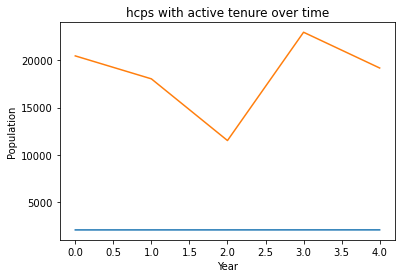

In [52]:
print("tenure over time for selected hcps:")
population_per_channel = basetable.groupby(["Year"])[["FLAG_TENURE"]].sum().reset_index()
population_per_channel.plot(legend=False, title="hcps with active tenure over time")
plt.xlabel("Year")
plt.ylabel("Population")
plt.show()
print()

### Add delay timings

In [53]:
df.INTRCTN_MTHD_UPD.value_counts()

Face to Face    59777
Phone           16843
Mail             7163
Virtual          3507
Postal           3342
Other            1546
Fax                26
MISSING             2
Name: INTRCTN_MTHD_UPD, dtype: int64

In [54]:
df.INTRCTN_MTHD.value_counts()

Face to Face            59773
Phone                   10327
Virtual Other            8735
Voice-only Call          6516
Email                    3341
Virtual MS Teams         2336
Virtual Zoom              849
Video                     322
Virtual Veeva Engage        5
Virtual MSL Eng@ge          2
Name: INTRCTN_MTHD, dtype: int64

In [55]:
print(f"Virtual = {2336+849+322}, F2F = {10327+6515}, MAIL = (3341), POSTAL =(8735)")

Virtual = 3507, F2F = 16842, MAIL = (3341), POSTAL =(8735)


In [56]:
df[(df.INTRCTN_MTHD_UPD == 'Phone')][['CUST_ID', 'INTRCTN_MTHD', 'INTRCTN_MTHD_UPD']]['INTRCTN_MTHD'].value_counts()

Phone              10327
Voice-only Call     6516
Name: INTRCTN_MTHD, dtype: int64

In [57]:
df[(df.CUST_ID == '001U000000TOcP5IAL')][['CUST_ID', 'DATA_PERIOD_MTH','INTRCTN_MTHD', 'INTRCTN_MTHD_UPD','TOT_F2F_CALL_CNT', 'TOT_VIRTUAL_CALL_CNT',
       'TOT_PHN_CALL_CNT', 'TOT_OTHR_CALL_CNT', 'TOT_RTE_SNT_CNT',
       'TOT_RTE_CLK_CNT', 'TOT_RTE_OPN_CNT', 'TOT_RTE_OPN_RT',
       'TOT_RTE_CLK_THRU_RT', 'TOT_HQ_SNT_CNT', 'TOT_HQ_CLK_CNT',
       'TOT_HQ_OPN_CNT', 'TOT_HQ_OPN_RT', 'TOT_HQ_CLK_THRU_RT']]

,CUST_ID,DATA_PERIOD_MTH,INTRCTN_MTHD,INTRCTN_MTHD_UPD,TOT_F2F_CALL_CNT,TOT_VIRTUAL_CALL_CNT,TOT_PHN_CALL_CNT,TOT_OTHR_CALL_CNT,TOT_RTE_SNT_CNT,TOT_RTE_CLK_CNT,TOT_RTE_OPN_CNT,TOT_RTE_OPN_RT,TOT_RTE_CLK_THRU_RT,TOT_HQ_SNT_CNT,TOT_HQ_CLK_CNT,TOT_HQ_OPN_CNT,TOT_HQ_OPN_RT,TOT_HQ_CLK_THRU_RT
0,001U000000TOcP5IAL,2023-02-01,Virtual Other,Postal,0,0,0,1,0,0,0,0.0,0.0,0,0,0,0.0,0.0
1,001U000000TOcP5IAL,2020-03-01,Phone,Phone,0,0,1,0,0,0,0,0.0,0.0,0,0,0,0.0,0.0
2,001U000000TOcP5IAL,2022-01-01,Face to Face,Face to Face,1,0,0,0,0,0,0,0.0,0.0,0,0,0,0.0,0.0
3,001U000000TOcP5IAL,2022-10-01,Virtual Other,Postal,0,0,0,1,0,0,0,0.0,0.0,0,0,0,0.0,0.0
4,001U000000TOcP5IAL,2021-06-01,Face to Face,Face to Face,1,0,0,0,0,0,0,0.0,0.0,0,0,0,0.0,0.0
5,001U000000TOcP5IAL,2021-10-01,Face to Face,Face to Face,1,0,0,0,0,0,0,0.0,0.0,0,0,0,0.0,0.0
6,001U000000TOcP5IAL,2019-05-01,Face to Face,Face to Face,1,0,0,0,0,0,0,0.0,0.0,0,0,0,0.0,0.0
7,001U000000TOcP5IAL,2019-01-01,Face to Face,Face to Face,1,0,0,0,0,0,0,0.0,0.0,0,0,0,0.0,0.0
8,001U000000TOcP5IAL,2019-11-01,Face to Face,Face to Face,1,0,0,0,0,0,0,0.0,0.0,0,0,0,0.0,0.0
9,001U000000TOcP5IAL,2021-02-01,Virtual Other,Other,0,0,0,1,0,0,0,0.0,0.0,0,0,0,0.0,0.0


In [58]:
# deriving time since last call in days
df['LST_CALL_DT'] = pd.to_datetime(df['LST_CALL_DT'])
df['DAYS_SINCE_LST_CALL'] = (pd.Timestamp.today() - df['LST_CALL_DT']).dt.days

In [76]:
commercial_df = df[df['DIVISION'] == 'COMMERCIAL']
med_df = df[df['DIVISION'] == 'MEDICAL']

In [77]:
# One-hot encoding for some categorical columns:
cols_to_encode = ['PROD_ID', 'TERR_ID', 'CALL_FOCUS', 'INTRCTN_STATUS', 'CALL_ATTENDEE_TYP', 'SLS_LN_CD', 'INTRCTN_MTHD', 'INTRCTN_MTHD_UPD', 'SALUTATN', 'HCP_TYPE',
                 'HCP_GNDR',  'HCP_STATUS', 'SPEC_NM', 'HCP_TENURE_MIN', 'HCP_TENURE_MAX', 'Month', 'Year']
commercial_df = pd.get_dummies(commercial_df, columns=cols_to_encode)
med_df = pd.get_dummies(med_df, columns=cols_to_encode)

In [78]:
# Selecting numerical features for scaling
features_to_scale = ['DAYS_SINCE_LST_CALL', 'TOT_RCH_TCHPNT_CNT', 'TOT_DIALOG_CNT', 'HCP_AGE']
scaler = StandardScaler()
commercial_df[features_to_scale] = scaler.fit_transform(commercial_df[features_to_scale])
med_df[features_to_scale] = scaler.fit_transform(med_df[features_to_scale])

In [89]:
from sklearn.cluster import KMeans

def perform_segmentation(dataframe):
    # Dropping non-encoded and non-numerical fields for clustering
    features_for_clustering = dataframe.drop(columns=['CUST_ID', 'PROD_NM', 'BRND_NM', 'TERR_NAME', 'HCP_FRST_NM', 'HCP_LST_NM', 'HCP_FULL_NM', 'HCP_ADDR', 'HCP_CITY_NM', 
                                           'HCP_PHN_NUM', 'HCP_EMAIL', 'HCP_LINKEDIN_URL', 'HCP_TWITTER_URL', 'LST_CALL_EMP_NM', 'LST_CALL_DT', 'LST_CALL_EMP_ID', 'LST_CALL_EMP_NM',
                                                     'BUSINESS_UNIT','DIVISION', 'EMP_ID', 'DATA_PERIOD_MTH', 'HCP_AGE']).columns
    
    kmeans = KMeans(n_clusters=4, random_state=42)
    
    clustering_data = dataframe[features_for_clustering]
    clustering_data = clustering_data.replace([np.inf, -np.inf], -9999)
    nan_columns = clustering_data.columns[clustering_data.isna().any()].tolist()
    print(nan_columns)
    clustering_data['DAYS_SINCE_LST_CALL'] = clustering_data['DAYS_SINCE_LST_CALL'].fillna(-9999)

    dataframe['Segment'] = kmeans.fit_predict(clustering_data)
    
    return dataframe

In [90]:
med_df = perform_segmentation(med_df)

['DAYS_SINCE_LST_CALL']


In [93]:
med_df[med_df['Segment'] == 2]

,CUST_ID,TERR_NAME,PROD_NM,BRND_NM,BUSINESS_UNIT,DIVISION,CALL_PRIORITY,EMP_ID,DATA_PERIOD_MTH,TOT_RCH_TCHPNT_CNT,TOT_DIALOG_CNT,TOT_F2F_CALL_CNT,TOT_VIRTUAL_CALL_CNT,TOT_PHN_CALL_CNT,TOT_OTHR_CALL_CNT,TOT_RTE_SNT_CNT,TOT_RTE_CLK_CNT,TOT_RTE_OPN_CNT,TOT_RTE_OPN_RT,TOT_RTE_CLK_THRU_RT,TOT_HQ_SNT_CNT,TOT_HQ_CLK_CNT,TOT_HQ_OPN_CNT,TOT_HQ_OPN_RT,TOT_HQ_CLK_THRU_RT,HCP_FRST_NM,HCP_LST_NM,HCP_FULL_NM,HCP_AGE,KOL_IND,PDRP_IND,HCP_ADDR,HCP_POSTAL_CD,HCP_CITY_NM,PRIM_ADDR_IND,HCP_PHN_NUM,HCP_EMAIL,HCP_LINKEDIN_URL,HCP_TWITTER_URL,LST_CALL_DT,LST_CALL_EMP_ID,LST_CALL_EMP_NM,MARKETING_PRODUCT_COUNT,total_products,FLAG_TENURE,CHANNEL_COUNTS,DAYS_SINCE_LST_CALL,PROD_ID_a006f00000drt9YAAQ,PROD_ID_a006f00000dsldlAAA,PROD_ID_a006f00000dsldvAAA,TERR_ID_0MI6f00000004SxGAI,TERR_ID_0MI6f00000004UoGAI,TERR_ID_0MI6f00000004V4GAI,TERR_ID_0MI6f00000004VJGAY,TERR_ID_0MI6f00000004VMGAY,TERR_ID_0MI6f00000004VPGAY,TERR_ID_0MI6f00000004VSGAY,TERR_ID_0MI6f00000004VVGAY,TERR_ID_0MI6f00000004VaGAI,TERR_ID_0MI6f00000004VhGAI,TERR_ID_0MI6f00000004VpGAI,TERR_ID_0MI6f00000004WEGAY,TERR_ID_0MI6f000000L1MMGA0,TERR_ID_0MI6f000000L1MRGA0,TERR_ID_0MI6f000000L1MWGA0,TERR_ID_0MI6f000000fysFGAQ,INTRCTN_STATUS_Submitted_vod,CALL_ATTENDEE_TYP_Person_Account_vod,SLS_LN_CD_Breast Cancer,SLS_LN_CD_Onco Medical Solid,SLS_LN_CD_PreCo,INTRCTN_MTHD_Email,INTRCTN_MTHD_Face to Face,INTRCTN_MTHD_Virtual MS Teams,INTRCTN_MTHD_Virtual MSL Eng@ge,INTRCTN_MTHD_Virtual Other,INTRCTN_MTHD_Virtual Zoom,INTRCTN_MTHD_Voice-only Call,INTRCTN_MTHD_UPD_Face to Face,INTRCTN_MTHD_UPD_MISSING,INTRCTN_MTHD_UPD_Mail,INTRCTN_MTHD_UPD_Other,INTRCTN_MTHD_UPD_Phone,INTRCTN_MTHD_UPD_Virtual,SALUTATN_Frau,SALUTATN_Herrn,HCP_TYPE_Business Professional,HCP_TYPE_Doctor,HCP_TYPE_Nurse,HCP_TYPE_Other Non-Prescribing HCP,HCP_GNDR_F,HCP_GNDR_M,HCP_STATUS_Active,SPEC_NM_Allgemeinmedizin,SPEC_NM_Anästhesiologie,SPEC_NM_Augenheilkunde,SPEC_NM_Biologie,SPEC_NM_Chirurgie,SPEC_NM_Chirurgie / Viszeralchirurgie,SPEC_NM_Fachwissenschaftler der Medizin,SPEC_NM_Frauenheilkunde und Geburtshilfe,SPEC_NM_Frauenheilkunde und Geburtshilfe / Gynäkologische Endokrinologie und Reproduktionsmedizin,SPEC_NM_Frauenheilkunde und Geburtshilfe / Gynäkologische Onkologie,SPEC_NM_Frauenheilkunde und Geburtshilfe / Spezielle Geburtshilfe und Perinatalmedizin,SPEC_NM_Hals-Nasen-Ohrenheilkunde,SPEC_NM_Haut- und Geschlechtskrankheiten,SPEC_NM_Humangenetik,SPEC_NM_Innere Medizin,SPEC_NM_Innere Medizin / Endokrinologie und Diabetologie,SPEC_NM_Innere Medizin / Gastroenterologie,SPEC_NM_Innere Medizin / Hämatologie und Internistische Onkologie,SPEC_NM_Innere Medizin / Kardiologie,SPEC_NM_Innere Medizin / Pneumologie,SPEC_NM_Krankenschwester / Pflegedienst,SPEC_NM_MTA,SPEC_NM_Medizinisch technischer Radiologieassistent,SPEC_NM_Medizinische Fachangestellte,SPEC_NM_Pathologie,SPEC_NM_Radiologie,SPEC_NM_Sekretärin,SPEC_NM_Sonstiges,SPEC_NM_Strahlentherapie,SPEC_NM_Verwaltung,HCP_TENURE_MIN_2019-01-01 00:00:00,HCP_TENURE_MIN_2019-02-01 00:00:00,HCP_TENURE_MIN_2019-03-01 00:00:00,HCP_TENURE_MIN_2019-04-01 00:00:00,HCP_TENURE_MIN_2019-05-01 00:00:00,HCP_TENURE_MIN_2019-06-01 00:00:00,HCP_TENURE_MIN_2019-07-01 00:00:00,HCP_TENURE_MIN_2019-08-01 00:00:00,HCP_TENURE_MIN_2019-09-01 00:00:00,HCP_TENURE_MIN_2019-10-01 00:00:00,HCP_TENURE_MIN_2019-11-01 00:00:00,HCP_TENURE_MIN_2019-12-01 00:00:00,HCP_TENURE_MIN_2020-01-01 00:00:00,HCP_TENURE_MIN_2020-02-01 00:00:00,HCP_TENURE_MIN_2020-03-01 00:00:00,HCP_TENURE_MIN_2020-04-01 00:00:00,HCP_TENURE_MIN_2020-05-01 00:00:00,HCP_TENURE_MIN_2020-06-01 00:00:00,HCP_TENURE_MIN_2020-07-01 00:00:00,HCP_TENURE_MIN_2020-08-01 00:00:00,HCP_TENURE_MIN_2020-09-01 00:00:00,HCP_TENURE_MIN_2020-10-01 00:00:00,HCP_TENURE_MIN_2020-11-01 00:00:00,HCP_TENURE_MIN_2020-12-01 00:00:00,HCP_TENURE_MIN_2021-02-01 00:00:00,HCP_TENURE_MIN_2021-03-01 00:00:00,HCP_TENURE_MIN_2021-04-01 00:00:00,HCP_TENURE_MIN_2021-05-01 00:00:00,HCP_TENURE_MIN_2021-06-01 00:00:00,HCP_TENURE_MIN_2021-07-01 00:00:00,HCP_TENURE_MIN_2021-08-01 00:00:00,HCP_TENUR

In [95]:
df.columns

Index(['CUST_ID', 'PROD_ID', 'TERR_ID', 'TERR_NAME', 'PROD_NM', 'BRND_NM',
       'SLS_LN_CD', 'CALL_FOCUS', 'INTRCTN_STATUS', 'CALL_ATTENDEE_TYP',
       'BUSINESS_UNIT', 'DIVISION', 'CALL_PRIORITY', 'INTRCTN_MTHD',
       'INTRCTN_MTHD_UPD', 'EMP_ID', 'DATA_PERIOD_MTH', 'TOT_RCH_TCHPNT_CNT',
       'TOT_DIALOG_CNT', 'TOT_F2F_CALL_CNT', 'TOT_VIRTUAL_CALL_CNT',
       'TOT_PHN_CALL_CNT', 'TOT_OTHR_CALL_CNT', 'TOT_RTE_SNT_CNT',
       'TOT_RTE_CLK_CNT', 'TOT_RTE_OPN_CNT', 'TOT_RTE_OPN_RT',
       'TOT_RTE_CLK_THRU_RT', 'TOT_HQ_SNT_CNT', 'TOT_HQ_CLK_CNT',
       'TOT_HQ_OPN_CNT', 'TOT_HQ_OPN_RT', 'TOT_HQ_CLK_THRU_RT', 'HCP_FRST_NM',
       'HCP_LST_NM', 'HCP_FULL_NM', 'SALUTATN', 'HCP_TYPE', 'HCP_GNDR',
       'HCP_AGE', 'HCP_STATUS', 'KOL_IND', 'PDRP_IND', 'HCP_ADDR',
       'HCP_POSTAL_CD', 'HCP_CITY_NM', 'PRIM_ADDR_IND', 'SPEC_NM',
       'HCP_PHN_NUM', 'HCP_EMAIL', 'HCP_LINKEDIN_URL', 'HCP_TWITTER_URL',
       'LST_CALL_DT', 'LST_CALL_EMP_ID', 'LST_CALL_EMP_NM',
       'MARKETING_PRO

In [98]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from scipy.stats import f_oneway

# 1. Statistical Validation

# Silhouette Score
sil_score = silhouette_score(med_df.drop('Segment', axis=1), med_df['Segment'])
print(f'Silhouette Score: {sil_score}')

# Variance Analysis (ANOVA for the 'income' column as an example)
f_stat, p_val = f_oneway(med_df[med_df['Segment'] == 0]['INTRCTN_MTHD_UPD'], 
                        med_df[med_df['Segment'] == 1]['INTRCTN_MTHD_UPD'], 
                        med_df[med_df['Segment'] == 2]['INTRCTN_MTHD_UPD'])
print(f"ANOVA F-Stat: {f_stat}, p-value: {p_val}")

# 2. Profile Each Segment
print(med_df.groupby('Segment').mean())

# 3. Segment Size
print(med_df['Segment'].value_counts())


ValueError: could not convert string to float: '001U000000TPXosIAH'